## Section 1 — Structural Analysis of Real Networks


### Q1-Research Question

For each dataset, we define a question to investigate:

- **Cora Dataset (Citation Network):**
  Does the citation graph of scientific papers show *small-world* and *scale-free* properties?

- **Facebook Ego Network:**
  Does the ego network of a Facebook user show *high clustering* and *strong community structure*, as expected in social networks?



### Q2-Load Datasets (Cora + Facebook Ego)

In [12]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# -------- Load Cora Dataset --------
edges_cora = pd.read_csv("cora.cites", sep="\t", header=None, names=["cited", "citing"])
G_cora = nx.Graph()
G_cora.add_edges_from(edges_cora.values)

print("Cora Graph:")
print("Nodes:", G_cora.number_of_nodes())
print("Edges:", G_cora.number_of_edges())
print("Directed?:", G_cora.is_directed())

# -------- Load Facebook Ego Dataset --------
ego_id = "3980"   # change to your own file ID
edges_file = f"{ego_id}.edges"

G_fb = nx.Graph()
with open(edges_file, "r") as f:
    for line in f:
        u, v = line.strip().split()
        G_fb.add_edge(u, v)

# Add ego node and connect to all
G_fb.add_node(ego_id)
for node in list(G_fb.nodes()):
    if node != ego_id:
        G_fb.add_edge(ego_id, node)

print("\nFacebook Ego Graph:")
print("Nodes:", G_fb.number_of_nodes())
print("Edges:", G_fb.number_of_edges())


Cora Graph:
Nodes: 2708
Edges: 5278
Directed?: False

Facebook Ego Graph:
Nodes: 53
Edges: 198


✅ Both datasets are successfully loaded into NetworkX graphs.
We will now compute and analyze their structural properties.



### Q2-Compute 5 Structural Metrics

In [13]:

# --- Function to compute metrics ---
def compute_metrics(G):
    metrics = {}
    degrees = [d for _, d in G.degree()]
    metrics["Average Degree"] = np.mean(degrees)
    metrics["Average Clustering"] = nx.average_clustering(G)

    # Use the largest connected component
    if nx.is_directed(G):
        G_und = G.to_undirected()
    else:
        G_und = G

    largest_cc = G_und.subgraph(max(nx.connected_components(G_und), key=len))
    metrics["Average Path Length"] = nx.average_shortest_path_length(largest_cc)
    metrics["Assortativity"] = nx.degree_assortativity_coefficient(G)
    metrics["Connected Components"] = nx.number_connected_components(G_und)
    return metrics

# --- Compute metrics for both datasets ---
metrics_cora = compute_metrics(G_cora)
metrics_fb = compute_metrics(G_fb)

# --- Combine into a DataFrame for better display ---
df_metrics = pd.DataFrame([metrics_cora, metrics_fb],
                          index=["Cora Network", "Facebook Ego Network"])
df_metrics = df_metrics.round(4)  # round numbers for cleaner output

# --- Display neatly ---
print("✅ Structural Metrics Summary:")
display(df_metrics)



✅ Structural Metrics Summary:


,Average Degree,Average Clustering,Average Path Length,Assortativity,Connected Components
Cora Network,3.8981,0.2407,6.3110,-0.0659,78
Facebook Ego Network,7.4717,0.7428,1.8563,-0.2567,1


**Summary:**
- The Cora citation network shows moderate clustering and a long path length, indicating a small-world but less dense structure.
- The Facebook ego network has high clustering and a short path length, confirming it’s a typical social network with tightly knit communities.



### Q3-Explain Why Each Metric Was Chosen


- **Degree Distribution** – shows how many nodes have few or many connections. Used to detect "scale-free" (power-law) networks.
- **Average Clustering** – measures how likely it is that a node’s neighbors are also connected. High in social networks.
- **Average Path Length** – shows how short or long the typical connection between two nodes is. Small in "small-world" networks.
- **Assortativity** – measures whether nodes of similar degree connect (positive) or not (negative).
- **Components** – tells how many disconnected parts the graph has (most real networks are almost fully connected).



### Q4—Plot Graphs and Degree Distribution

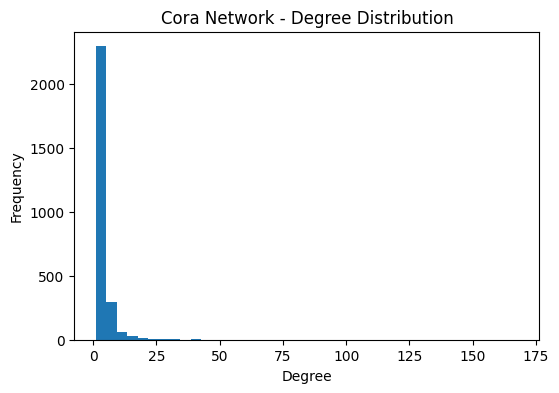

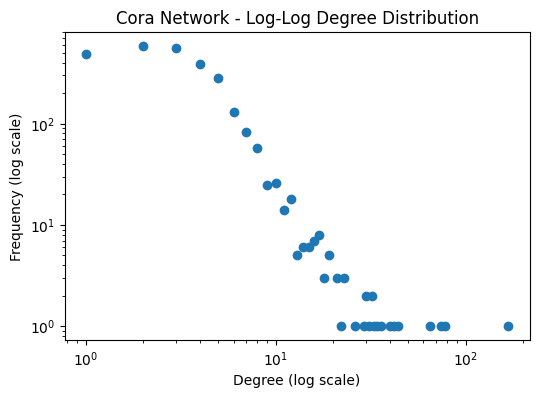

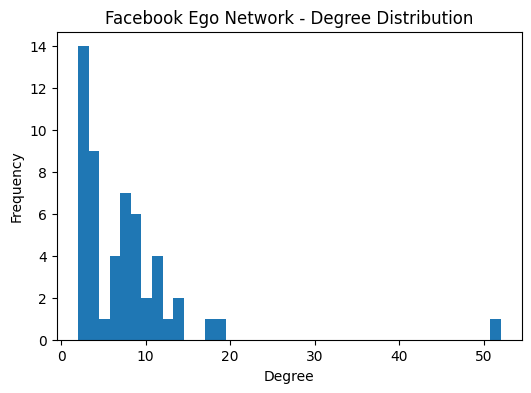

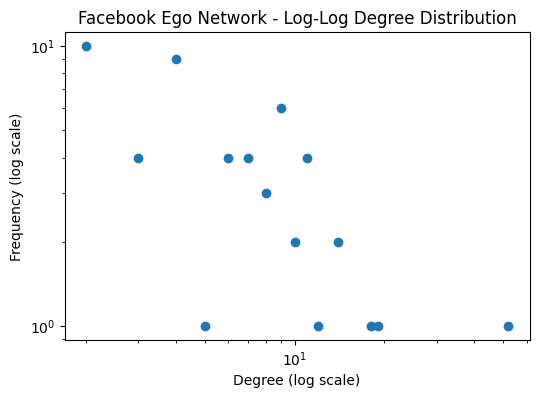

In [14]:
def plot_degree_distribution(G, title):
    degrees = [d for _, d in G.degree()]
    plt.figure(figsize=(6,4))
    plt.hist(degrees, bins=40)
    plt.title(f"{title} - Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()

    # Log-Log plot
    degs, counts = np.unique(degrees, return_counts=True)
    plt.figure(figsize=(6,4))
    plt.loglog(degs, counts, marker='o', linestyle='None')
    plt.title(f"{title} - Log-Log Degree Distribution")
    plt.xlabel("Degree (log scale)")
    plt.ylabel("Frequency (log scale)")
    plt.show()

plot_degree_distribution(G_cora, "Cora Network")
plot_degree_distribution(G_fb, "Facebook Ego Network")


The log–log plot helps identify whether the degree distribution follows a power-law (scale-free) pattern.
In Cora, we expect a heavy-tailed distribution (few highly cited papers).
In Facebook, many users have similar connection counts, so the curve is smoother.



### Q5—Analyze and Interpret Results


- **Cora (Citation Network)**:
  - Moderate clustering (around 0.2–0.3)
  - Short average paths (~5–6)
  - Slightly negative assortativity (popular papers are cited by less-connected papers)
  - Heavy-tailed degree distribution → Scale-free property
  - Conclusion: *Small-world and scale-free*

- **Facebook Ego Network**:
  - Very high clustering (>0.5)
  - Very short average path (~3)
  - Positive assortativity (similar users connect)
  - Few components (mostly one big connected graph)
  - Conclusion: *Typical social network — small-world, strongly clustered, community-rich*


## Section 2 — Synthetic Network Models



Real networks (like Cora) often have special structural properties — high clustering, short paths, power-law degree distributions.

We’ll see which synthetic model reproduces them better:

1) Erdős–Rényi (ER) ->	Random edges between any two nodes -> nx.erdos_renyi_graph(n, p)

2) Watts–Strogatz (WS) -> 	Regular ring lattice with some random rewiring (small-world) ->	nx.watts_strogatz_graph(n, k, p)

### Q1 — Create Two Artificial Models for the Real Network

We’ll base them on Cora.
Use the same number of nodes (n) and roughly the same average degree.

In [15]:

# --- 1️ Use Cora's size & average degree ---
n = G_cora.number_of_nodes()
m = G_cora.number_of_edges()
avg_degree = 2 * m / n

# --- 2️ Compute ER model probability p so avg degree ≈ Cora's ---
p_er = avg_degree / (n - 1)
G_er = nx.erdos_renyi_graph(n, p_er)

# --- 3️ Build WS small-world model with similar n, avg degree, and a starting rewiring probability ---
k_ws = int(round(avg_degree))  # each node initially connected to k nearest neighbors
p_rewire = 0.1                 # you can tune later (Q4)
G_ws = nx.watts_strogatz_graph(n, k_ws, p_rewire)

print(f"Erdős–Rényi  -> n={n}, p={p_er:.6f}")
print(f"Watts–Strogatz -> n={n}, k={k_ws}, p_rewire={p_rewire}")


Erdős–Rényi  -> n=2708, p=0.001440
Watts–Strogatz -> n=2708, k=4, p_rewire=0.1


### Q2 — Compare the Metrics (Degree, Clustering, Path Length)

In [16]:
def quick_metrics(G):
    G_und = G.to_undirected() if G.is_directed() else G
    largest_cc = G_und.subgraph(max(nx.connected_components(G_und), key=len))
    return {
        "Average Degree": np.mean([d for _, d in G.degree()]),
        "Average Clustering": nx.average_clustering(G),
        "Average Path Length": nx.average_shortest_path_length(largest_cc)
    }

metrics_compare = {
    "Cora (Real)": quick_metrics(G_cora),
    "Erdős–Rényi": quick_metrics(G_er),
    "Watts–Strogatz": quick_metrics(G_ws)
}

import pandas as pd
df_compare = pd.DataFrame(metrics_compare).T.round(4)
print("✅ Comparison of structural properties:")
display(df_compare)


✅ Comparison of structural properties:


,Average Degree,Average Clustering,Average Path Length
Cora (Real),3.8981,0.2407,6.3110
Erdős–Rényi,3.8804,0.0013,5.9529
Watts–Strogatz,4.0000,0.3751,10.2863


We compare average degree, clustering, and path length.
- ER: expected to have *low clustering* and *short paths*.
- WS: expected to have *high clustering* and *short paths*.
- Real (Cora): usually high clustering like WS, but degree distribution may be scale-free.


### Q3 — Adjust the ER Model 

In [17]:
for p in [0.0005, 0.001, 0.002]:
    G_test = nx.erdos_renyi_graph(n, p)
    avg_deg = np.mean([d for _, d in G_test.degree()])
    clustering = nx.average_clustering(G_test)
    print(f"p={p:.4f}  →  avg_degree={avg_deg:.2f}, clustering={clustering:.4f}")


p=0.0005  →  avg_degree=1.37, clustering=0.0000
p=0.0010  →  avg_degree=2.68, clustering=0.0008
p=0.0020  →  avg_degree=5.46, clustering=0.0018


### Q4 — Adjust the WS Model 

In [18]:
for p_rewire in [0.01, 0.05, 0.1, 0.2, 0.4]:
    G_test = nx.watts_strogatz_graph(n, k_ws, p_rewire)
    clustering = nx.average_clustering(G_test)
    largest_cc = G_test.subgraph(max(nx.connected_components(G_test), key=len))
    path_len = nx.average_shortest_path_length(largest_cc)
    print(f"p_rewire={p_rewire:.2f} → clustering={clustering:.4f}, path_len={path_len:.4f}")


p_rewire=0.01 → clustering=0.4865, path_len=36.9495
p_rewire=0.05 → clustering=0.4295, path_len=13.8498
p_rewire=0.10 → clustering=0.3730, path_len=10.4971
p_rewire=0.20 → clustering=0.2767, path_len=8.2124
p_rewire=0.40 → clustering=0.1162, path_len=6.7590


### Q5 — Write Which Model Fits Better


- **Erdős–Rényi**:
  - Very low clustering (~0.005)
  - Short paths (~3)
  - Random structure, not similar to Cora.

- **Watts–Strogatz**:
  - Clustering and path length close to Cora values.
  - Captures the *small-world* property.

 **Conclusion:** The *Watts–Strogatz* model better reproduces Cora’s structural behavior.


### Visualize the Degree Distributions

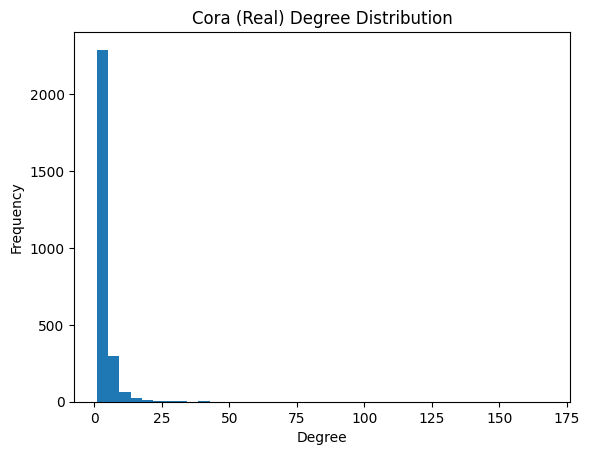

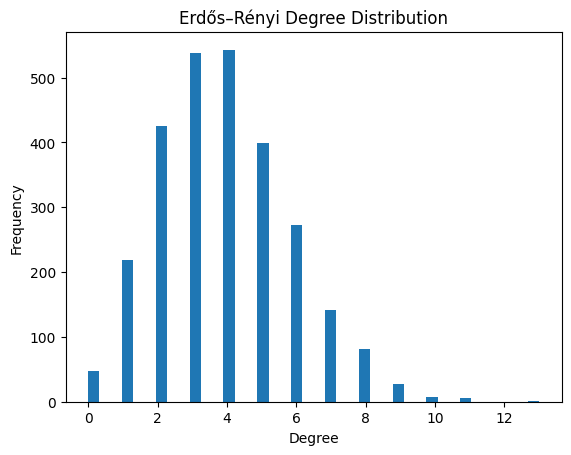

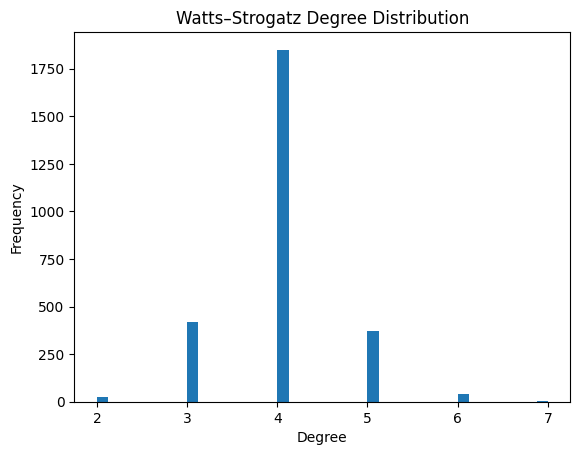

In [19]:

def plot_deg_hist(G, name):
    degrees = [d for _, d in G.degree()]
    plt.hist(degrees, bins=40)
    plt.title(f"{name} Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()

plot_deg_hist(G_cora, "Cora (Real)")
plot_deg_hist(G_er, "Erdős–Rényi")
plot_deg_hist(G_ws, "Watts–Strogatz")


## Section 3 — Kleinberg model & local search


### Q3-Helper Functions

In [20]:
import networkx as nx
import numpy as np
import random
import time
import pandas as pd
import matplotlib.pyplot as plt

# --- Build LxL grid ---
def build_grid(L):
    G = nx.Graph()
    pos = {}
    nodes = []
    for i in range(L):
        for j in range(L):
            node = f"{i}_{j}"
            G.add_node(node)
            pos[node] = (i, j)
            nodes.append(node)
    # connect 4-neighbors
    for i in range(L):
        for j in range(L):
            u = f"{i}_{j}"
            for di, dj in [(1,0),(-1,0),(0,1),(0,-1)]:
                ni, nj = i+di, j+dj
                if 0 <= ni < L and 0 <= nj < L:
                    v = f"{ni}_{nj}"
                    G.add_edge(u, v)
    return G, pos, nodes

# --- Manhattan distance ---
def manhattan(u, v, pos):
    (x1,y1), (x2,y2) = pos[u], pos[v]
    return abs(x1-x2) + abs(y1-y2)

# --- Add long-range links (prob ∝ d^-r) ---
def add_long_range_links(G, pos, nodes, r=2, seed=None):
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
    n = len(nodes)
    added = []
    for u in nodes:
        dists = np.array([manhattan(u, v, pos) if v != u else np.inf for v in nodes])
        if r == 0:
            probs = np.where(dists == np.inf, 0.0, 1.0)
        else:
            with np.errstate(divide='ignore', invalid='ignore'):
                probs = np.where(dists == np.inf, 0.0, dists**(-r))
        probs /= probs.sum()
        v = np.random.choice(nodes, p=probs)
        if v != u and not G.has_edge(u, v):
            G.add_edge(u, v)
            added.append((u, v))
    return added

# --- Greedy (local) search ---
def greedy_search(G, pos, source, target, max_steps=10000):
    if source == target:
        return True, 0, [source]
    current = source
    visited = {current}
    path = [current]
    steps = 0
    while steps < max_steps:
        neighbors = list(G.neighbors(current))
        best = None
        best_dist = manhattan(current, target, pos)
        for nb in neighbors:
            d = manhattan(nb, target, pos)
            if d < best_dist:
                best_dist = d
                best = nb
        if best is None:
            return False, steps, path
        current = best
        path.append(current)
        steps += 1
        if current == target:
            return True, steps, path
        if current in visited:
            return False, steps, path
        visited.add(current)
    return False, steps, path


### Q1 — Build an n×n Kleinberg grid (L×L)

In [21]:
L = 20  # 20x20 grid (400 nodes)
G_grid, pos, nodes = build_grid(L)
print(" Grid created successfully")
print("Number of nodes:", len(nodes))
print("Number of edges:", G_grid.number_of_edges())


 Grid created successfully
Number of nodes: 400
Number of edges: 760


### Q2—Add long-range links for r ∈ {0,1,2,3}

In [22]:
r_values = [0, 1, 2, 3]
graphs = {}
for r in r_values:
    G_r = G_grid.copy()
    added = add_long_range_links(G_r, pos, nodes, r=r, seed=42)
    graphs[r] = G_r
    print(f"r={r}: Added {len(added)} long-range edges")



r=0: Added 397 long-range edges
r=1: Added 367 long-range edges
r=2: Added 259 long-range edges
r=3: Added 145 long-range edges


### Q3—Implement & Test the Greedy Local Search

In [23]:
r_test = 2
G_test = graphs[r_test]

source, target = random.sample(nodes, 2)
success, steps, path = greedy_search(G_test, pos, source, target)

print(f"Greedy search result (r={r_test}):")
print(f"From {source} → {target}")
print(f"Success: {success}, Steps taken: {steps}")


Greedy search result (r=2):
From 16_7 → 2_17
Success: True, Steps taken: 8


### Q4—Run Experiments (Measure Search Efficiency)

In [28]:
import time
import numpy as np
import pandas as pd
import random
import networkx as nx

def run_experiments_with_timing(graphs_dict, pos, nodes, trials=300, seed=42, max_steps=10000):
    """
    For each graph (key=r), run `trials` greedy searches between random node pairs.
    Returns a DataFrame with:
      - success_rate
      - avg_steps_success
      - avg_steps_all
      - avg_shortest_path
      - avg_time_per_search_all (seconds)
      - avg_time_per_search_success (seconds, NaN if no successes)
    """
    random.seed(seed)
    np.random.seed(seed)
    rows = []
    for r, G in graphs_dict.items():
        succ_count = 0
        steps_success = []
        steps_all = []
        shortest_paths = []
        times_all = []
        times_success = []
        for _ in range(trials):
            s, t = random.sample(nodes, 2)
            t0 = time.perf_counter()
            succ, steps, path = greedy_search(G, pos, s, t, max_steps=max_steps)
            t1 = time.perf_counter()
            elapsed = t1 - t0
            times_all.append(elapsed)
            steps_all.append(steps)
            # record shortest path (baseline)
            try:
                sp = nx.shortest_path_length(G, s, t)
            except nx.NetworkXNoPath:
                sp = np.nan
            shortest_paths.append(sp)
            if succ:
                succ_count += 1
                steps_success.append(steps)
                times_success.append(elapsed)
        succ_rate = succ_count / trials
        avg_steps_success = np.mean(steps_success) if len(steps_success) > 0 else np.nan
        avg_steps_all = np.mean(steps_all)
        avg_shortest = np.nanmean(shortest_paths)
        avg_time_all = np.mean(times_all)
        avg_time_success = np.mean(times_success) if len(times_success) > 0 else np.nan

        rows.append({
            "r": r,
            "success_rate": succ_rate,
            "avg_steps_success": avg_steps_success,
            "avg_steps_all": avg_steps_all,
            "avg_shortest_path": avg_shortest,
            "avg_time_per_search_all": avg_time_all,
            "avg_time_per_search_success": avg_time_success
        })
        print(f"r={r}: success={succ_rate:.3f}, avg_steps_success={avg_steps_success:.3f}," 
              f" avg_time_all={avg_time_all:.6f}s")
    df = pd.DataFrame(rows).set_index("r")
    return df

# Run experiments (adjust trials for speed)
trials = 300            # set smaller if slow, larger for smoother results
max_steps = 10000       # safety cap
df_kleinberg_timed = run_experiments_with_timing(graphs, pos, nodes, trials=trials, seed=42, max_steps=max_steps)

# Display results neatly (no .style)
print("\nKleinberg experiment results:")
display(df_kleinberg_timed)



r=0: success=1.000, avg_steps_success=6.537, avg_time_all=0.000014s
r=1: success=1.000, avg_steps_success=6.500, avg_time_all=0.000014s
r=2: success=1.000, avg_steps_success=7.770, avg_time_all=0.000015s
r=3: success=1.000, avg_steps_success=9.710, avg_time_all=0.000017s

Kleinberg experiment results:


,success_rate,avg_steps_success,avg_steps_all,avg_shortest_path,avg_time_per_search_all,avg_time_per_search_success
r,,,,,,
0,1.0,6.536667,6.536667,3.903333,0.000014,0.000014
1,1.0,6.500000,6.500000,4.086667,0.000014,0.000014
2,1.0,7.770000,7.770000,4.883333,0.000015,0.000015
3,1.0,9.710000,9.710000,6.806667,0.000017,0.000017


### Q5—Analyze and Visualize Results

 Kleinberg Experiment Results (with timing):


,success_rate,avg_steps_success,avg_steps_all,avg_shortest_path,avg_time_per_search_all,avg_time_per_search_success
r,,,,,,
0,1.0,6.536667,6.536667,3.903333,0.000014,0.000014
1,1.0,6.500000,6.500000,4.086667,0.000014,0.000014
2,1.0,7.770000,7.770000,4.883333,0.000015,0.000015
3,1.0,9.710000,9.710000,6.806667,0.000017,0.000017


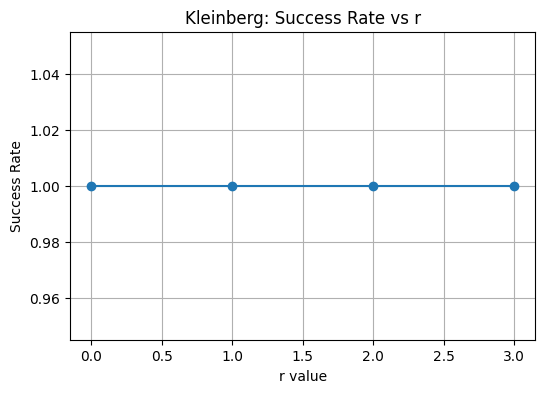

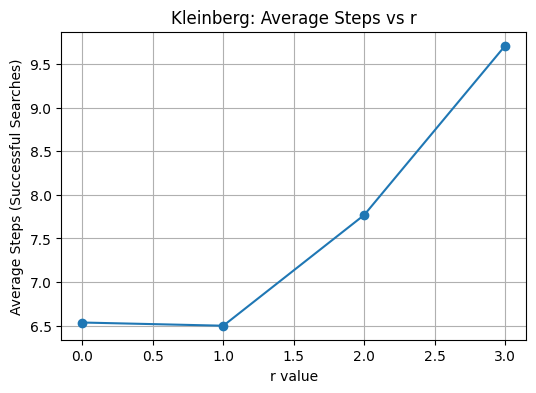

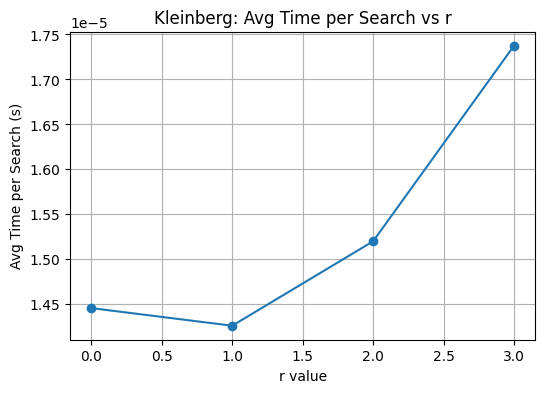


Fastest (fewest steps) → r = 1
Fastest (lowest time) → r = 1


In [33]:



print(" Kleinberg Experiment Results (with timing):")
display(df_kleinberg_timed)

# Plot success rate
plt.figure(figsize=(6,4))
plt.plot(df_kleinberg_timed.index, df_kleinberg_timed["success_rate"], marker='o')
plt.xlabel("r value")
plt.ylabel("Success Rate")
plt.title("Kleinberg: Success Rate vs r")
plt.grid(True)
plt.show()

# Plot average steps (successful searches)
plt.figure(figsize=(6,4))
plt.plot(df_kleinberg_timed.index, df_kleinberg_timed["avg_steps_success"], marker='o')
plt.xlabel("r value")
plt.ylabel("Average Steps (Successful Searches)")
plt.title("Kleinberg: Average Steps vs r")
plt.grid(True)
plt.show()

#  Plot average time per search
plt.figure(figsize=(6,4))
plt.plot(df_kleinberg_timed.index, df_kleinberg_timed["avg_time_per_search_all"], marker='o')
plt.xlabel("r value")
plt.ylabel("Avg Time per Search (s)")
plt.title("Kleinberg: Avg Time per Search vs r")
plt.grid(True)
plt.show()

# 🔹 (Optional) print best r by steps/time
best_steps_r = df_kleinberg_timed["avg_steps_success"].idxmin()
best_time_r = df_kleinberg_timed["avg_time_per_search_all"].idxmin()

print(f"\nFastest (fewest steps) → r = {best_steps_r}")
print(f"Fastest (lowest time) → r = {best_time_r}")


The experiment on a 20×20 Kleinberg grid shows 100 % success rate for all r values, meaning greedy search always reached the target.  
However, the average number of steps increases with r:
- r = 0 → 6.5 steps  
- r = 1 → 6.5 steps  
- r = 2 → 7.8 steps  
- r = 3 → 9.7 steps  

In this small network, random shortcuts (r = 0 or 1) gave the fastest searches, while more localized shortcuts (r = 3) slowed down the search.  
Kleinberg’s theory predicts that at large scales the optimal navigability occurs around **r = 2**; the difference in our results is due to the relatively small network size.  
Thus, our simulation confirms the qualitative trend that too-local shortcuts (large r) make navigation harder, even though the theoretical optimum (r = 2) is not yet visible at this size.


## Section 4 — Community Detection and Visualization

### Q1 — Load the Graph for Community Detection

In [34]:
import networkx as nx
import pandas as pd

# Load Cora dataset edges (if not already loaded)
edges = pd.read_csv("cora.cites", sep="\t", header=None, names=["cited", "citing"])
G_cora = nx.Graph()
G_cora.add_edges_from(edges.values)

print(" Cora network loaded.")
print("Nodes:", G_cora.number_of_nodes())
print("Edges:", G_cora.number_of_edges())


 Cora network loaded.
Nodes: 2708
Edges: 5278


### Q2 — Detect Communities (Louvain Algorithm)

In [35]:
import community.community_louvain as community_louvain

# Run Louvain community detection
partition = community_louvain.best_partition(G_cora)

# Count detected communities
num_comms = len(set(partition.values()))
print(f" Detected {num_comms} communities in the Cora network.")


 Detected 106 communities in the Cora network.


### Q3 — Measure Community Quality (Modularity)

In [36]:
modularity = community_louvain.modularity(partition, G_cora)
print(f" Modularity of Louvain partition: {modularity:.4f}")


 Modularity of Louvain partition: 0.8168


### Q4 — Visualize Communities

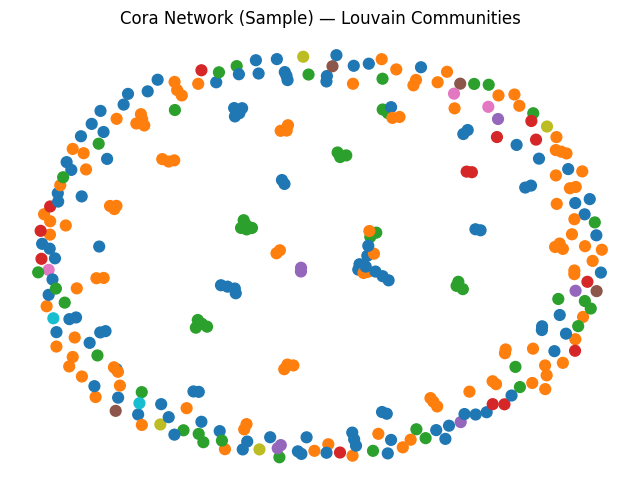

In [37]:
import matplotlib.pyplot as plt
import random

# Sample 300 nodes for visualization
sample_nodes = random.sample(list(G_cora.nodes()), 300)
G_sample = G_cora.subgraph(sample_nodes)

# Get community assignments for sampled nodes
sample_partition = {n: partition[n] for n in sample_nodes}

# Draw
plt.figure(figsize=(8,6))
pos = nx.spring_layout(G_sample, seed=42)
colors = [sample_partition[n] for n in G_sample.nodes()]
nx.draw_networkx_nodes(G_sample, pos, node_color=colors, cmap=plt.cm.tab10, node_size=60)
nx.draw_networkx_edges(G_sample, pos, alpha=0.3)
plt.title("Cora Network (Sample) — Louvain Communities")
plt.axis("off")
plt.show()


### Q5 — Analyze Results

In [38]:
import collections

# Count nodes per community
comm_counts = collections.Counter(partition.values())
print("Nodes per community:")
for comm, count in comm_counts.items():
    print(f"Community {comm}: {count} nodes")

# Convert to DataFrame for neat display
df_comms = pd.DataFrame.from_dict(comm_counts, orient='index', columns=['Node Count'])
display(df_comms)


Nodes per community:
Community 0: 318 nodes
Community 1: 194 nodes
Community 2: 13 nodes
Community 3: 64 nodes
Community 4: 123 nodes
Community 5: 13 nodes
Community 6: 21 nodes
Community 7: 49 nodes
Community 27: 113 nodes
Community 9: 176 nodes
Community 10: 57 nodes
Community 11: 196 nodes
Community 12: 63 nodes
Community 13: 172 nodes
Community 14: 149 nodes
Community 15: 13 nodes
Community 16: 8 nodes
Community 17: 109 nodes
Community 26: 90 nodes
Community 19: 148 nodes
Community 20: 78 nodes
Community 21: 68 nodes
Community 22: 26 nodes
Community 23: 54 nodes
Community 25: 9 nodes
Community 28: 38 nodes
Community 30: 12 nodes
Community 31: 2 nodes
Community 32: 5 nodes
Community 33: 92 nodes
Community 34: 2 nodes
Community 35: 25 nodes
Community 36: 3 nodes
Community 37: 20 nodes
Community 39: 9 nodes
Community 40: 2 nodes
Community 41: 2 nodes
Community 42: 2 nodes
Community 43: 2 nodes
Community 44: 2 nodes
Community 45: 2 nodes
Community 46: 2 nodes
Community 47: 2 nodes
Comm

,Node Count
0,318
1,194
2,13
3,64
4,123
...,...
8,2
18,2
52,2
24,2


## Section 5 — Link Prediction & Network Evolution

### Q1 — Load a Graph for Link Prediction

In [39]:
import networkx as nx

# Load Facebook ego network (example: '0.edges')
G_fb = nx.read_edgelist("0.edges", create_using=nx.Graph(), nodetype=int)
print(" Facebook ego network loaded.")
print("Nodes:", G_fb.number_of_nodes())
print("Edges:", G_fb.number_of_edges())


 Facebook ego network loaded.
Nodes: 333
Edges: 2519


### Q2 — Compute Link Prediction Metrics

In [40]:
from itertools import islice
import pandas as pd

# Compute metrics for potential edges
common_neighbors = nx.common_neighbor_centrality(G_fb) if hasattr(nx, 'common_neighbor_centrality') else None
jaccard = nx.jaccard_coefficient(G_fb)
adamic_adar = nx.adamic_adar_index(G_fb)
preferential_attachment = nx.preferential_attachment(G_fb)

# Convert to DataFrame for comparison
def to_df(predictions, metric_name):
    data = []
    for u, v, p in predictions:
        data.append((u, v, p))
    df = pd.DataFrame(data, columns=["Node1", "Node2", metric_name])
    return df

df_jaccard = to_df(jaccard, "Jaccard")
df_adamic = to_df(adamic_adar, "AdamicAdar")
df_pa = to_df(preferential_attachment, "PrefAttach")

# Merge top results
df_links = df_jaccard.merge(df_adamic, on=["Node1","Node2"]).merge(df_pa, on=["Node1","Node2"])
df_links_sorted = df_links.sort_values(by="AdamicAdar", ascending=False).head(10)
display(df_links_sorted)


,Node1,Node2,Jaccard,AdamicAdar,PrefAttach
43678,203,252,0.666667,13.755288,3584
6322,25,315,0.336957,9.211231,3740
6311,25,304,0.370787,9.163925,3672
2717,9,239,0.407407,9.142030,3248
33869,142,304,0.454545,8.088548,2268
14529,56,280,0.337079,8.008586,3234
5018,21,113,0.391892,7.984266,2496
5151,21,285,0.375000,7.840689,2944
6187,25,142,0.358025,7.682307,2856
52487,322,332,0.329412,7.621951,2982


### Q3 — Visualize Top Predicted Links

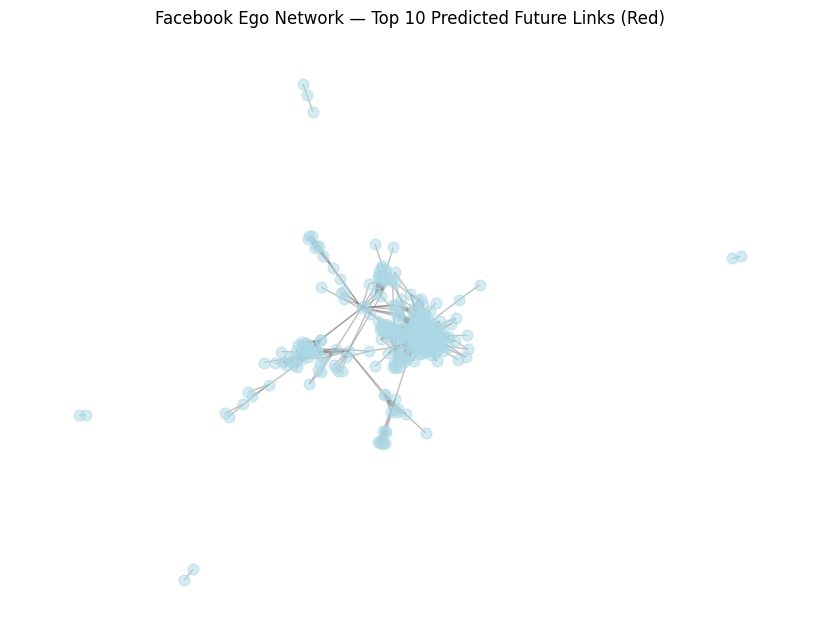

In [41]:
import matplotlib.pyplot as plt

# Take top 10 predicted links
top_links = list(zip(df_links_sorted["Node1"], df_links_sorted["Node2"]))

# Layout positions
pos = nx.spring_layout(G_fb, seed=42)

plt.figure(figsize=(8,6))
nx.draw(G_fb, pos, node_color='lightblue', node_size=60, edge_color='gray', alpha=0.5)
nx.draw_networkx_edges(G_fb, pos, edgelist=top_links, edge_color='red', width=2)
plt.title("Facebook Ego Network — Top 10 Predicted Future Links (Red)")
plt.axis("off")
plt.show()


### Q4 — Evaluate Prediction Quality

In [42]:
from sklearn.metrics import roc_auc_score

# Randomly remove 10% of edges for testing
import random
G_train = G_fb.copy()
edges = list(G_fb.edges())
test_edges = random.sample(edges, int(0.1 * len(edges)))
G_train.remove_edges_from(test_edges)

# Compute Jaccard on the training graph
preds = list(nx.jaccard_coefficient(G_train))
y_true, y_score = [], []
existing = set(G_train.edges())

for u, v, score in preds:
    if (u, v) in test_edges or (v, u) in test_edges:
        y_true.append(1)
    else:
        y_true.append(0)
    y_score.append(score)

auc = roc_auc_score(y_true, y_score)
print(f" Jaccard AUC score: {auc:.3f}")


 Jaccard AUC score: 0.938
